# EXERCICE 7 : REGRESSION LINEAIRE MULTIPLE AVEC REGULARISATION + VALIDATION CROISEE


Inspire de http://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_and_elasticnet.html


In [2]:

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error


#### Génération de donnée synthétiques...

In [6]:

np.random.seed(31)

#... definition de n et p
n = 75
p =  200   #remarque : n<200 => necessite de selectionner des variables

#... simulation de X
X = np.random.randn(n, p) #remarque : on ne tient pas en compte les $beta_0$

#... generation du vecteur beta dans lequel seules 10 valeurs sont non-nulles
beta = 3 * np.random.randn(p)
inds = np.arange(p)
np.random.shuffle(inds)
beta[inds[10:]] = 0 

#... simulation de y 
y = np.dot(X, beta) + (2.0 * np.random.normal(size=n))


# REMARQUE IMPORTANTE : y ne dépend que des variables i pour lesquelles beta[i] est non-nul


# ... coupe en deux les donnees en donnees d'apprentissage et donnes test
thresh=n // 2
X_train = X[thresh:]
y_train = y[thresh:]
X_test = X[:thresh]
y_test = y[:thresh]


#### Régression linéaire avec régularisation Lasso ...


In [8]:

from sklearn.linear_model import Lasso

alpha = 0.5
lasso_regressor = Lasso(alpha=alpha)
lasso_regressor.fit(X_train, y_train)

y_pred_lasso = lasso_regressor.predict(X_test)
mse_score_lasso = mean_squared_error(y_test, y_pred_lasso)


####  Représentation du résultat


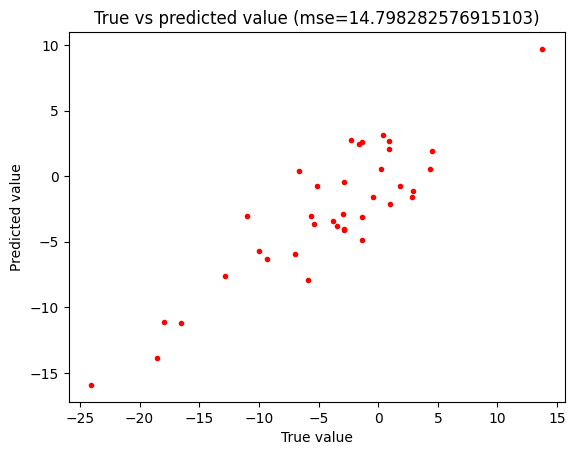

In [5]:
fig = plt.figure()
plt.plot(y_test, y_pred_lasso, 'r.')
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.title('True vs predicted value (mse='+str(mse_score_lasso)+')')
plt.show()



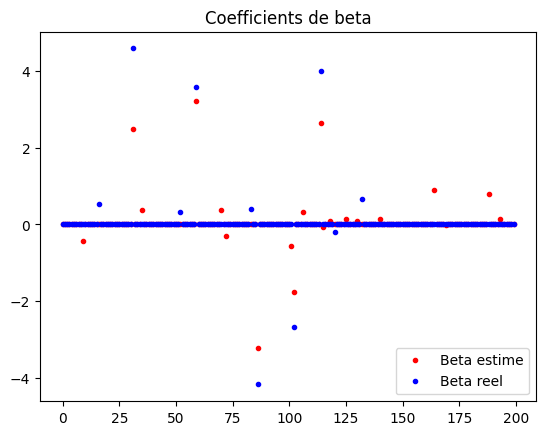

In [9]:

fig = plt.figure()
plt.plot(lasso_regressor.coef_, 'r.')
plt.plot(beta, 'b.')
plt.legend(('Beta estime', 'Beta reel'), loc='lower right')
plt.title('Coefficients de beta')
plt.show()



### <span style="color:blue">QUESTION 1</span> :

Jouez l'exemple avec  n=1000, n=100, n=75, n=50, n=25. Qu'en deduisez vous sur l'impact du nombre d'observations

### <span style="color:blue">REPONSE 1</span> :

...


n=1000 => mse=5.279790602029447
n=100 => mse=10.793454139884984
n=75 => mse=31.22794502934659
n=50 => mse=35.39659085368409
n=25 => mse=95.2412020072647


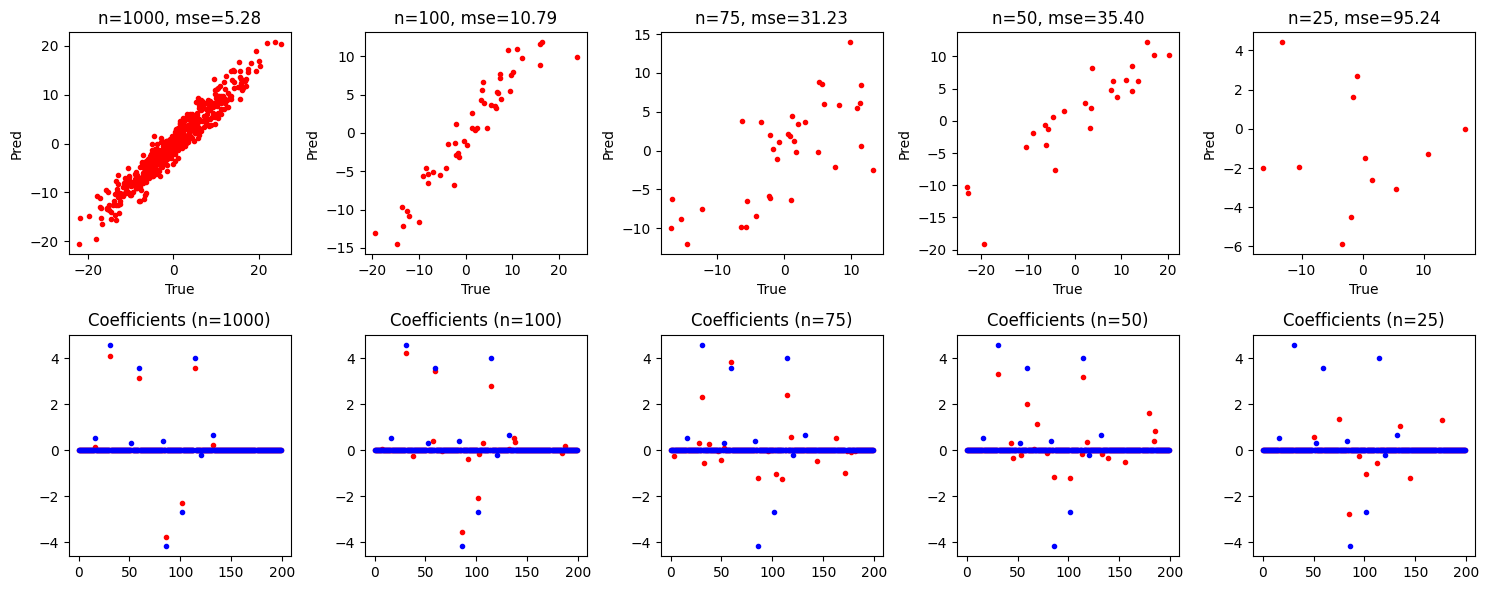

In [10]:
n_vecteur=[1000,100,75,50,25]
p=200
alpha=0.5
fig, axes = plt.subplots(2, len(n_vecteur), figsize=(15, 6))

for i, n in enumerate(n_vecteur):
    X = np.random.randn(n, p)
    y = np.dot(X, beta) + (2.0 * np.random.normal(size=n))
    thresh = n // 2
    X_train, y_train = X[thresh:], y[thresh:]
    X_test, y_test = X[:thresh], y[:thresh]

    lasso_regressor = Lasso(alpha=alpha)
    lasso_regressor.fit(X_train, y_train)
    y_pred_lasso = lasso_regressor.predict(X_test)
    mse_score_lasso = mean_squared_error(y_test, y_pred_lasso)
    print("n=" + str(n) + " => mse=" + str(mse_score_lasso))

    # 1ère ligne : y_true vs y_pred
    axes[0, i].plot(y_test, y_pred_lasso, 'r.')
    axes[0, i].set_title(f"n={n}, mse={mse_score_lasso:.2f}")
    axes[0, i].set_xlabel("True")
    axes[0, i].set_ylabel("Pred")

    # 2ème ligne : coefficients
    axes[1, i].plot(lasso_regressor.coef_, 'r.', label="Estimated")
    axes[1, i].plot(beta, 'b.', label="True")
    axes[1, i].set_title(f"Coefficients (n={n})")

plt.tight_layout()
plt.show()
# Remarque : on constate que lorsque n diminue, la qualité de l'estimation diminue aussi
# et que le nombre de coefficients non-nuls estimés augmente (plus de bruit)
# En effet, lorsque n diminue, le problème devient de plus en plus mal posé
# (on a de moins en moins d'information pour estimer les p coefficients)
# et on a donc de plus en plus de mal à retrouver les 10 variables réellement explicatives
# (on retrouve de plus en plus de variables non explicatives, c'est du bruit)
# Ceci est un exemple d'overfitting (sur-apprentissage) : le modèle se "mémorise" les données d'apprentissage
# mais n'arrive pas à généraliser sur des données de test
# (ici, on a un modèle trop complexe par rapport à la quantité d'information disponible)
# Pour lutter contre l'overfitting, on peut utiliser des méthodes de régularisation         

    


### <span style="color:blue">QUESTION 2</span> :

On garde n=75. Utilisez la validation croisee de type K-folds (typiquement 8-Folds) pour trouver le meilleur coefficient *alpha* au sens de la MSE. Pour chaque *alpha* testé, on gardera comme score la MSE moyenne obtenue sur tous les *folds*.

Remarque : la recherche d'un bon coefficient *alpha* pourra d'abord se faire sur une échelle exponentielle assez large (ex: 0.001, 0.01, 0.1, ...) puis être raffinée sur une échelle plus fine.  

### <span style="color:blue">REPONSE 2</span> :

In [11]:

from sklearn.model_selection import KFold
n=75
p=200
X = np.random.randn(n, p)
y = np.dot(X, beta) + (2.0 * np.random.normal(size=n))
thresh = n // 2
X_train = X[thresh:]
y_train = y[thresh:]
X_test = X[:thresh]
y_test = y[:thresh]
#...
kf = KFold(n_splits=8, shuffle=True)
mse_list = []
alpha_list = [0.45,0.46,0.47,0.48,0.49,0.5,0.51, 0.52, 0.53, 0.54, 0.55]
for alpha in alpha_list:
    mse_folds = []
    for train_index, val_index in kf.split(X_train):
        X_tr, X_val = X_train[train_index], X_train[val_index]
        y_tr, y_val = y_train[train_index], y_train[val_index]

        lasso_regressor = Lasso(alpha=alpha)
        lasso_regressor.fit(X_tr, y_tr)
        y_val_pred = lasso_regressor.predict(X_val)
        mse_folds.append(mean_squared_error(y_val, y_val_pred))

    avg_mse = np.mean(mse_folds)
    mse_list.append(avg_mse)
    print(f"Alpha: {alpha}, Average MSE: {avg_mse}")





Alpha: 0.45, Average MSE: 16.923306469338538
Alpha: 0.46, Average MSE: 29.368669880656004
Alpha: 0.47, Average MSE: 26.122944939580886
Alpha: 0.48, Average MSE: 17.179201532762065
Alpha: 0.49, Average MSE: 18.89398512608986
Alpha: 0.5, Average MSE: 22.675012251231813
Alpha: 0.51, Average MSE: 18.143314974365676
Alpha: 0.52, Average MSE: 15.011993960658415
Alpha: 0.53, Average MSE: 23.984271225993957
Alpha: 0.54, Average MSE: 14.429729712460693
Alpha: 0.55, Average MSE: 20.857266199368784


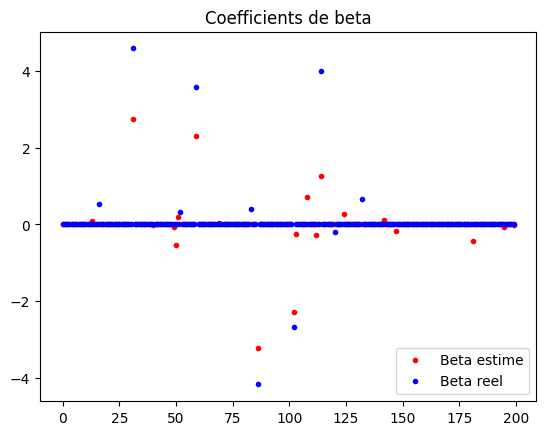

In [13]:
#représentation des coefficients estimés (lasso_regressor.coef_) et de ceux
#avec lesquels les données ont été simulées (beta)

fig = plt.figure()
alpha=alpha_list[np.argmin(mse_list)]
# alpha=0.2
lasso_regressor = Lasso(alpha=alpha)
lasso_regressor.fit(X_tr, y_tr)
plt.plot(lasso_regressor.coef_, 'r.')
plt.plot(beta, 'b.')
plt.legend(('Beta estime', 'Beta reel'), loc='lower right')
plt.title('Coefficients de beta')
plt.show()


### <span style="color:blue">QUESTION 3</span> :

De manère alternative, codez et testez maintenant une sélection de type *forward* avec un critère de sélection *BIC*.

Comparez les résultats avec ceux obtenus à l'aide de la pénalisation LASSO.

### <span style="color:blue">REPONSE 3</span> :


In [14]:

from sklearn.linear_model import LinearRegression

# forward selection with BIC criterion
n=75
p=200
X = np.random.randn(n, p)
y = np.dot(X, beta) + (2.0 * np.random.normal(size=n))
thresh = n // 2
X_train = X[thresh:]
y_train = y[thresh:]
X_test = X[:thresh]
y_test = y[:thresh]
forward_selected_features = []
remaining_features = list(range(X_train.shape[1]))
current_score, best_new_score = float('inf'), float('inf')
forward_selected_features = []
remaining_features = list(range(X_train.shape[1]))
current_score = float('inf')

while remaining_features:
    scores_with_candidates = []
    for candidate in remaining_features:
        features_to_test = forward_selected_features + [candidate]
        X_train_subset = X_train[:, features_to_test]
        model = LinearRegression().fit(X_train_subset, y_train)
        y_pred = model.predict(X_train_subset)
        
        mse = mean_squared_error(y_train, y_pred)
        n_samples = X_train.shape[0]
        n_features = len(features_to_test)
        rss = mse * n_samples
        bic = n_samples * np.log(rss / n_samples) + n_features * np.log(n_samples)
        
        scores_with_candidates.append((bic, candidate))

    scores_with_candidates.sort()
    best_new_score, best_candidate = scores_with_candidates[0]

    if best_new_score < current_score:
        remaining_features.remove(best_candidate)
        forward_selected_features.append(best_candidate)
        current_score = best_new_score
        print("Selected features:", forward_selected_features)
    else:
        break
print("Final selected features:", forward_selected_features)     





Selected features: [86]
Selected features: [86, 31]
Selected features: [86, 31, 114]
Selected features: [86, 31, 114, 59]
Selected features: [86, 31, 114, 59, 102]
Selected features: [86, 31, 114, 59, 102, 142]
Selected features: [86, 31, 114, 59, 102, 142, 16]
Selected features: [86, 31, 114, 59, 102, 142, 16, 44]
Selected features: [86, 31, 114, 59, 102, 142, 16, 44, 162]
Selected features: [86, 31, 114, 59, 102, 142, 16, 44, 162, 116]
Selected features: [86, 31, 114, 59, 102, 142, 16, 44, 162, 116, 39]
Selected features: [86, 31, 114, 59, 102, 142, 16, 44, 162, 116, 39, 157]
Selected features: [86, 31, 114, 59, 102, 142, 16, 44, 162, 116, 39, 157, 68]
Selected features: [86, 31, 114, 59, 102, 142, 16, 44, 162, 116, 39, 157, 68, 131]
Selected features: [86, 31, 114, 59, 102, 142, 16, 44, 162, 116, 39, 157, 68, 131, 121]
Selected features: [86, 31, 114, 59, 102, 142, 16, 44, 162, 116, 39, 157, 68, 131, 121, 180]
Selected features: [86, 31, 114, 59, 102, 142, 16, 44, 162, 116, 39, 157,